# Pre-layout Parameterized PCB

This example shows how to use the EDB interface along with HFSS 3D Layout to create and solve a
parameterized layout. The layout shows a differential via transition on a printed circuit board
with back-to-back microstrip to stripline transitions.
The model is fully parameterized to enable investigation of the transition performance on the
many degrees of freedom.

The resulting model is shown below

<img src="_static\pre_layout_parameterized_pcb.png" width="500">

## Preparation
Import the required packages

In [1]:
import os
import tempfile
import time

from ansys.aedt.core import Hfss3dLayout
from pyedb import Edb


## Define constants

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Launch EDB

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")
aedb_path = os.path.join(temp_folder.name, "pcb.aedb")
edb = Edb(edbpath=aedb_path, edbversion=AEDT_VERSION)

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `edbversion` is deprecated for method `Edb`; use `version` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyEDB INFO: Star initializing Edb 12:17:58.906035


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: create_edb completed in 8.5858 seconds.


PyEDB INFO: EDB C:\Users\ansys\AppData\Local\Temp\tmpfuoqt4jt.ansys\pcb.aedb created correctly.


PyEDB INFO: EDB initialization completed in 8.6655 seconds.


## Create layout
### Define the parameters.

In [4]:
params = {
    "$ms_width": "0.4mm",
    "$sl_width": "0.2mm",
    "$ms_spacing": "0.2mm",
    "$sl_spacing": "0.1mm",
    "$via_spacing": "0.5mm",
    "$via_diam": "0.3mm",
    "$pad_diam": "0.6mm",
    "$anti_pad_diam": "0.7mm",
    "$pcb_len": "15mm",
    "$pcb_w": "5mm",
    "$x_size": "1.2mm",
    "$y_size": "1mm",
    "$corner_rad": "0.5mm",
}

for par_name in params:
    edb.add_project_variable(par_name, params[par_name])

### Create stackup
Define the stackup layers from bottom to top.

In [5]:
layers = [
    {
        "name": "bottom",
        "layer_type": "signal",
        "thickness": "35um",
        "material": "copper",
    },
    {
        "name": "diel_3",
        "layer_type": "dielectric",
        "thickness": "275um",
        "material": "FR4_epoxy",
    },
    {
        "name": "sig_2",
        "layer_type": "signal",
        "thickness": "35um",
        "material": "copper",
    },
    {
        "name": "diel_2",
        "layer_type": "dielectric",
        "thickness": "275um",
        "material": "FR4_epoxy",
    },
    {
        "name": "sig_1",
        "layer_type": "signal",
        "thickness": "35um",
        "material": "copper",
    },
    {
        "name": "diel_1",
        "layer_type": "dielectric",
        "thickness": "275um",
        "material": "FR4_epoxy",
    },
    {"name": "top", "layer_type": "signal", "thickness": "35um", "material": "copper"},
]

Define the bottom layer

In [6]:
prev = None
for layer in layers:
    edb.stackup.add_layer(
        layer["name"],
        base_layer=prev,
        layer_type=layer["layer_type"],
        thickness=layer["thickness"],
        material=layer["material"],
    )
    prev = layer["name"]

### Create a parametrized padstack for the signal via.
Create a padstack definition.

In [7]:
signal_via_padstack = "automated_via"
edb.padstacks.create(
    padstackname=signal_via_padstack,
    holediam="$via_diam",
    paddiam="$pad_diam",
    antipaddiam="",
    antipad_shape="Bullet",
    x_size="$x_size",
    y_size="$y_size",
    corner_radius="$corner_rad",
    start_layer=layers[-1]["name"],
    stop_layer=layers[-3]["name"],
)

PyEDB INFO: Padstack automated_via create correctly


'automated_via'

Assign net names. There are only two signal nets.

In [8]:
net_p = "p"
net_n = "n"

Place the signal vias.

In [9]:
edb.padstacks.place(
    position=["$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing)/2"],
    definition_name=signal_via_padstack,
    net_name=net_p,
    via_name="",
    rotation=90.0,
)

In [10]:
edb.padstacks.place(
    position=["2*$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing)/2"],
    definition_name=signal_via_padstack,
    net_name=net_p,
    via_name="",
    rotation=90.0,
)

In [11]:
edb.padstacks.place(
    position=["$pcb_len/3", "-($ms_width+$ms_spacing+$via_spacing)/2"],
    definition_name=signal_via_padstack,
    net_name=net_n,
    via_name="",
    rotation=-90.0,
)

In [12]:
edb.padstacks.place(
    position=["2*$pcb_len/3", "-($ms_width+$ms_spacing+$via_spacing)/2"],
    definition_name=signal_via_padstack,
    net_name=net_n,
    via_name="",
    rotation=-90.0,
)

### Draw parametrized traces

Trace width and the routing (Microstrip-Stripline-Microstrip).
Applies to both p and n nets.

In [13]:
# Trace width, n and p
width = ["$ms_width", "$sl_width", "$ms_width"]
# Routing layer, n and p
route_layer = [layers[-1]["name"], layers[4]["name"], layers[-1]["name"]]

Define points for three traces in the "p" net

In [14]:
points_p = [
    [
        ["0.0", "($ms_width+$ms_spacing)/2"],
        ["$pcb_len/3-2*$via_spacing", "($ms_width+$ms_spacing)/2"],
        ["$pcb_len/3-$via_spacing", "($ms_width+$ms_spacing+$via_spacing)/2"],
        ["$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing)/2"],
    ],
    [
        ["$pcb_len/3", "($ms_width+$sl_spacing+$via_spacing)/2"],
        ["$pcb_len/3+$via_spacing", "($ms_width+$sl_spacing+$via_spacing)/2"],
        ["$pcb_len/3+2*$via_spacing", "($sl_width+$sl_spacing)/2"],
        ["2*$pcb_len/3-2*$via_spacing", "($sl_width+$sl_spacing)/2"],
        ["2*$pcb_len/3-$via_spacing", "($ms_width+$sl_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3", "($ms_width+$sl_spacing+$via_spacing)/2"],
    ],
    [
        ["2*$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3+$via_spacing", "($ms_width+$ms_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3+2*$via_spacing", "($ms_width+$ms_spacing)/2"],
        ["$pcb_len", "($ms_width+$ms_spacing)/2"],
    ],
]

Define points for three traces in the "n" net

In [15]:
points_n = [
    [
        ["0.0", "-($ms_width+$ms_spacing)/2"],
        ["$pcb_len/3-2*$via_spacing", "-($ms_width+$ms_spacing)/2"],
        ["$pcb_len/3-$via_spacing", "-($ms_width+$ms_spacing+$via_spacing)/2"],
        ["$pcb_len/3", "-($ms_width+$ms_spacing+$via_spacing)/2"],
    ],
    [
        ["$pcb_len/3", "-($ms_width+$sl_spacing+$via_spacing)/2"],
        ["$pcb_len/3+$via_spacing", "-($ms_width+$sl_spacing+$via_spacing)/2"],
        ["$pcb_len/3+2*$via_spacing", "-($ms_width+$sl_spacing)/2"],
        ["2*$pcb_len/3-2*$via_spacing", "-($ms_width+$sl_spacing)/2"],
        ["2*$pcb_len/3-$via_spacing", "-($ms_width+$sl_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3", "-($ms_width+$sl_spacing+$via_spacing)/2"],
    ],
    [
        ["2*$pcb_len/3", "-($ms_width+$ms_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3 + $via_spacing", "-($ms_width+$ms_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3 + 2*$via_spacing", "-($ms_width+$ms_spacing)/2"],
        ["$pcb_len", "-($ms_width + $ms_spacing)/2"],
    ],
]

Add traces to the EDB.

In [16]:
trace_p = []
trace_n = []
for n in range(len(points_p)):
    trace_p.append(edb.modeler.create_trace(points_p[n], route_layer[n], width[n], net_p, "Flat", "Flat"))
    trace_n.append(edb.modeler.create_trace(points_n[n], route_layer[n], width[n], net_n, "Flat", "Flat"))

Create the wave ports

In [17]:
edb.hfss.create_differential_wave_port(
    trace_p[0].id,
    ["0.0", "($ms_width+$ms_spacing)/2"],
    trace_n[0].id,
    ["0.0", "-($ms_width+$ms_spacing)/2"],
    "wave_port_1",
)
edb.hfss.create_differential_wave_port(
    trace_p[2].id,
    ["$pcb_len", "($ms_width+$ms_spacing)/2"],
    trace_n[2].id,
    ["$pcb_len", "-($ms_width + $ms_spacing)/2"],
    "wave_port_2",
)

('wave_port_2',
 <pyedb.dotnet.database.edb_data.ports.BundleWavePort at 0x26c4119b4f0>)

Draw a conducting rectangle on the the ground layers.

In [18]:
gnd_poly = [
    [0.0, "-$pcb_w/2"],
    ["$pcb_len", "-$pcb_w/2"],
    ["$pcb_len", "$pcb_w/2"],
    [0.0, "$pcb_w/2"],
]
gnd_shape = edb.modeler.Shape("polygon", points=gnd_poly)

Void in ground for traces on the signal routing layer

In [19]:
void_poly = [
    [
        "$pcb_len/3",
        "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2-$via_spacing/2",
    ],
    [
        "$pcb_len/3 + $via_spacing",
        "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2-$via_spacing/2",
    ],
    [
        "$pcb_len/3 + 2*$via_spacing",
        "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2",
    ],
    [
        "2*$pcb_len/3 - 2*$via_spacing",
        "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2",
    ],
    [
        "2*$pcb_len/3 - $via_spacing",
        "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2-$via_spacing/2",
    ],
    [
        "2*$pcb_len/3",
        "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2-$via_spacing/2",
    ],
    [
        "2*$pcb_len/3",
        "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2+$via_spacing/2",
    ],
    [
        "2*$pcb_len/3 - $via_spacing",
        "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2+$via_spacing/2",
    ],
    [
        "2*$pcb_len/3 - 2*$via_spacing",
        "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2",
    ],
    [
        "$pcb_len/3 + 2*$via_spacing",
        "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2",
    ],
    [
        "$pcb_len/3 + $via_spacing",
        "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2+$via_spacing/2",
    ],
    [
        "$pcb_len/3",
        "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2+$via_spacing/2",
    ],
    ["$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2"],
]

void_shape = edb.modeler.Shape("polygon", points=void_poly)

Add ground conductors.

In [20]:
for layer in layers[:-1:2]:

    # add void if the layer is the signal routing layer.
    void = [void_shape] if layer["name"] == route_layer[1] else []

    edb.modeler.create_polygon(main_shape=gnd_shape, layer_name=layer["name"], voids=void, net_name="gnd")

Plot the layout.

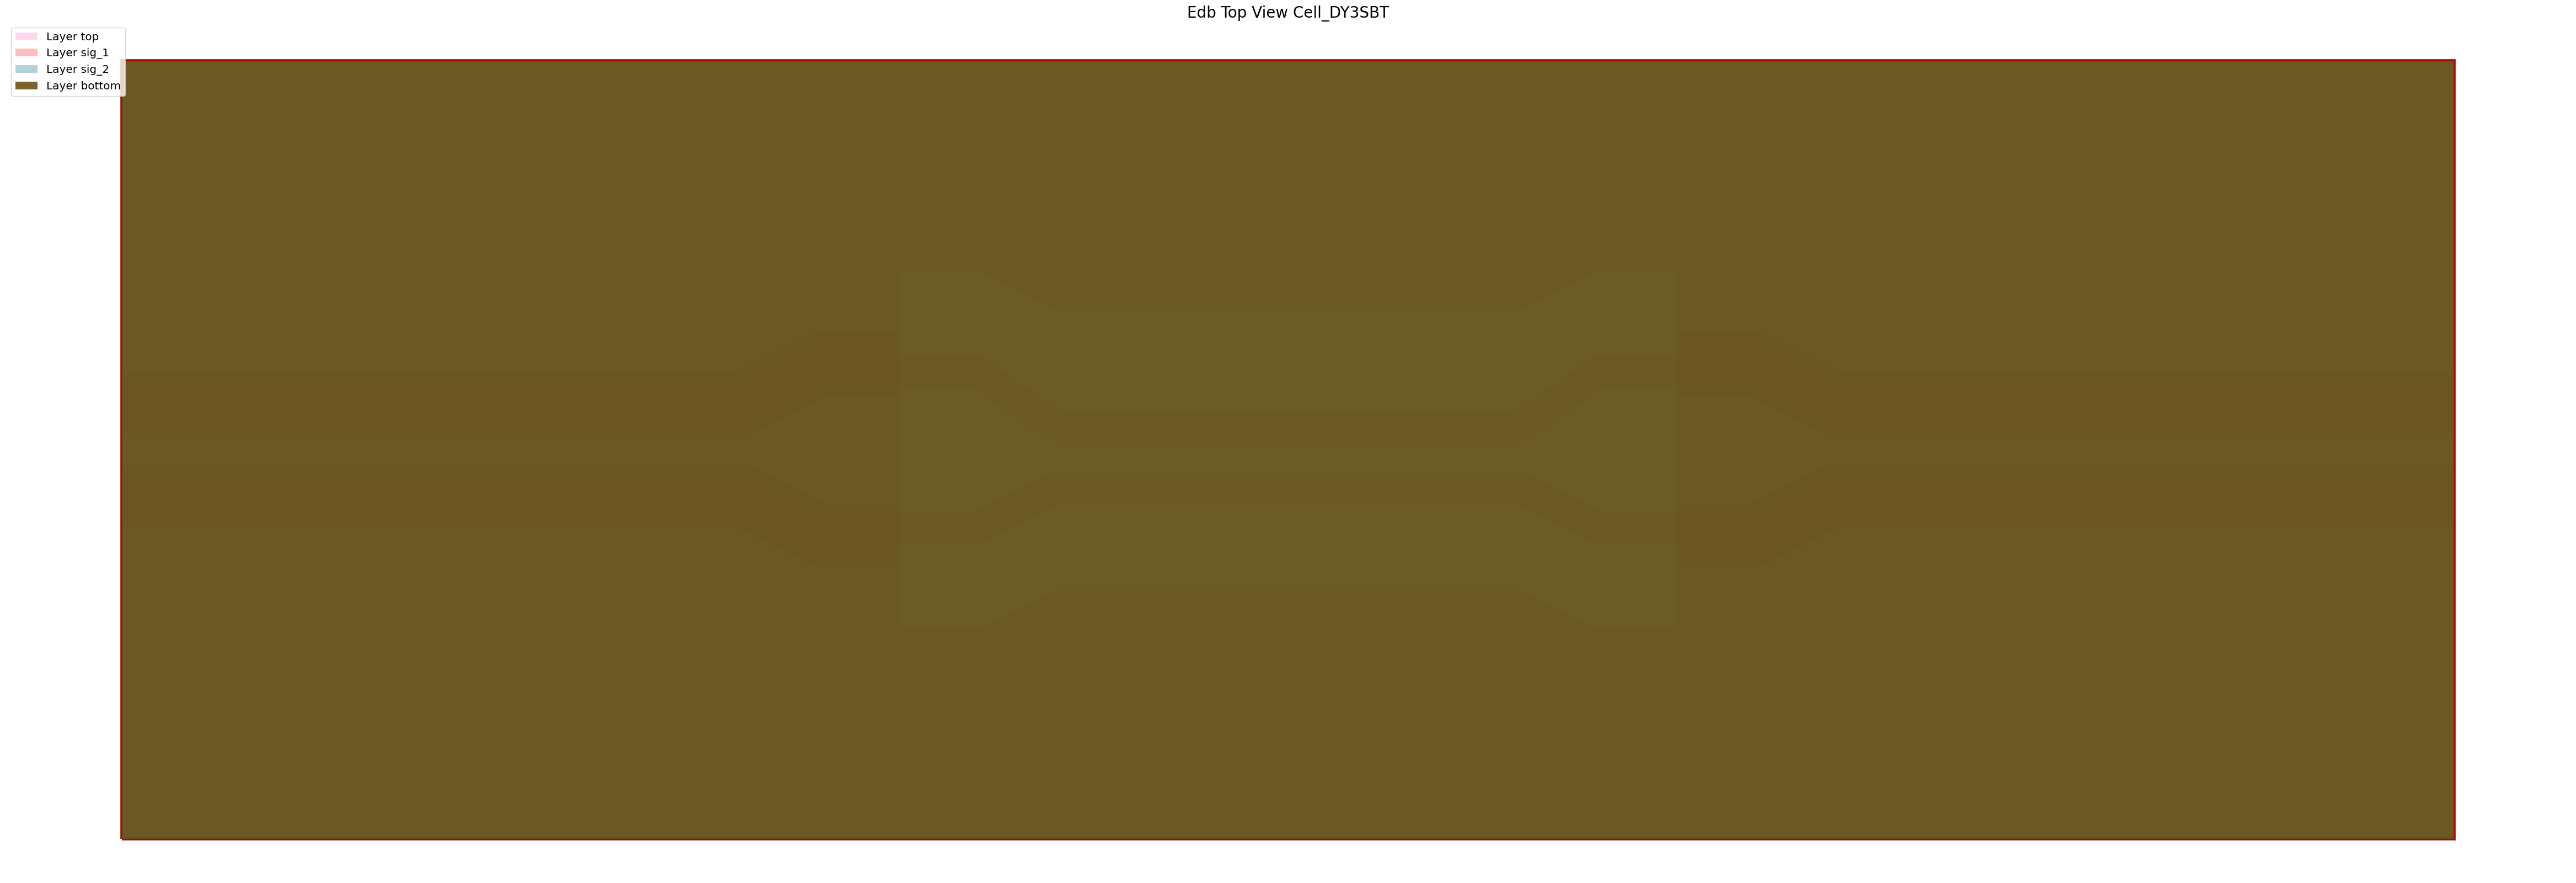

PyEDB INFO: Plot Generation time 0.571


(<Figure size 6000x3000 with 1 Axes>,
 <Axes: title={'center': 'Edb Top View Cell_DY3SBT'}>)

In [21]:
edb.nets.plot(None)

Save the EDB.

In [22]:
edb.save_edb()
edb.close_edb()

PyEDB INFO: Save Edb file completed in 0.0000 seconds.


PyEDB INFO: Close Edb file completed in 0.0159 seconds.


True

## Open the project in HFSS 3D Layout.

In [23]:
h3d = Hfss3dLayout(
    project=aedb_path,
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    new_desktop=True,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_080647c5-88c6-42d6-b6bf-9d136b95c535.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 1012.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmpfuoqt4jt.ansys\pcb.aedb has been imported to project pcb


PyAEDT INFO: Active Design set to 0;Cell_DY3SBT


PyAEDT INFO: Active Design set to 0;Cell_DY3SBT


PyAEDT INFO: Aedt Objects correctly read


### Add a HFSS simulation setup

In [24]:
setup = h3d.create_setup()
setup.props["AdaptiveSettings"]["SingleFrequencyDataList"]["AdaptiveFrequencyData"]["MaxPasses"] = 3

h3d.create_linear_count_sweep(
    setup=setup.name,
    unit="GHz",
    start_frequency=0,
    stop_frequency=10,
    num_of_freq_points=101,
    name="sweep1",
    sweep_type="Interpolating",
    interpolation_tol_percent=1,
    interpolation_max_solutions=255,
    save_fields=False,
    use_q3d_for_dc=False,
)

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpfuoqt4jt.ansys\pcb.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpfuoqt4jt.ansys\pcb.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.03145933151245117


PyAEDT INFO: Linear count sweep sweep1 has been correctly created.


MySetupAuto : sweep1

### Define the differential pairs to used to calculate differential and common mode  s-parameters

In [25]:
h3d.set_differential_pair(differential_mode="In", assignment="wave_port_1:T1", reference="wave_port_1:T2")
h3d.set_differential_pair(differential_mode="Out", assignment="wave_port_2:T1", reference="wave_port_2:T2")

True

Solve the project.

In [26]:
h3d.analyze(cores=NUM_CORES)

PyAEDT INFO: Project pcb Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 1.0m 51.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


True

Plot the results and shut down AEDT.

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpfuoqt4jt.ansys\pcb.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpfuoqt4jt.ansys\pcb.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.033838748931884766


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Loading Modeler.


PyAEDT INFO: Modeler loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyEDB INFO: Star initializing Edb 12:20:33.927748


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database pcb.aedb Opened in 2025.2


PyEDB INFO: Cell Cell_DY3SBT Opened


PyEDB INFO: Builder was initialized.


PyEDB INFO: open_edb completed in 0.0160 seconds.


PyEDB INFO: EDB initialization completed in 0.0317 seconds.


PyAEDT INFO: EDB loaded.


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.02375054359436035
Time to initialize solution data:0.03886151313781738


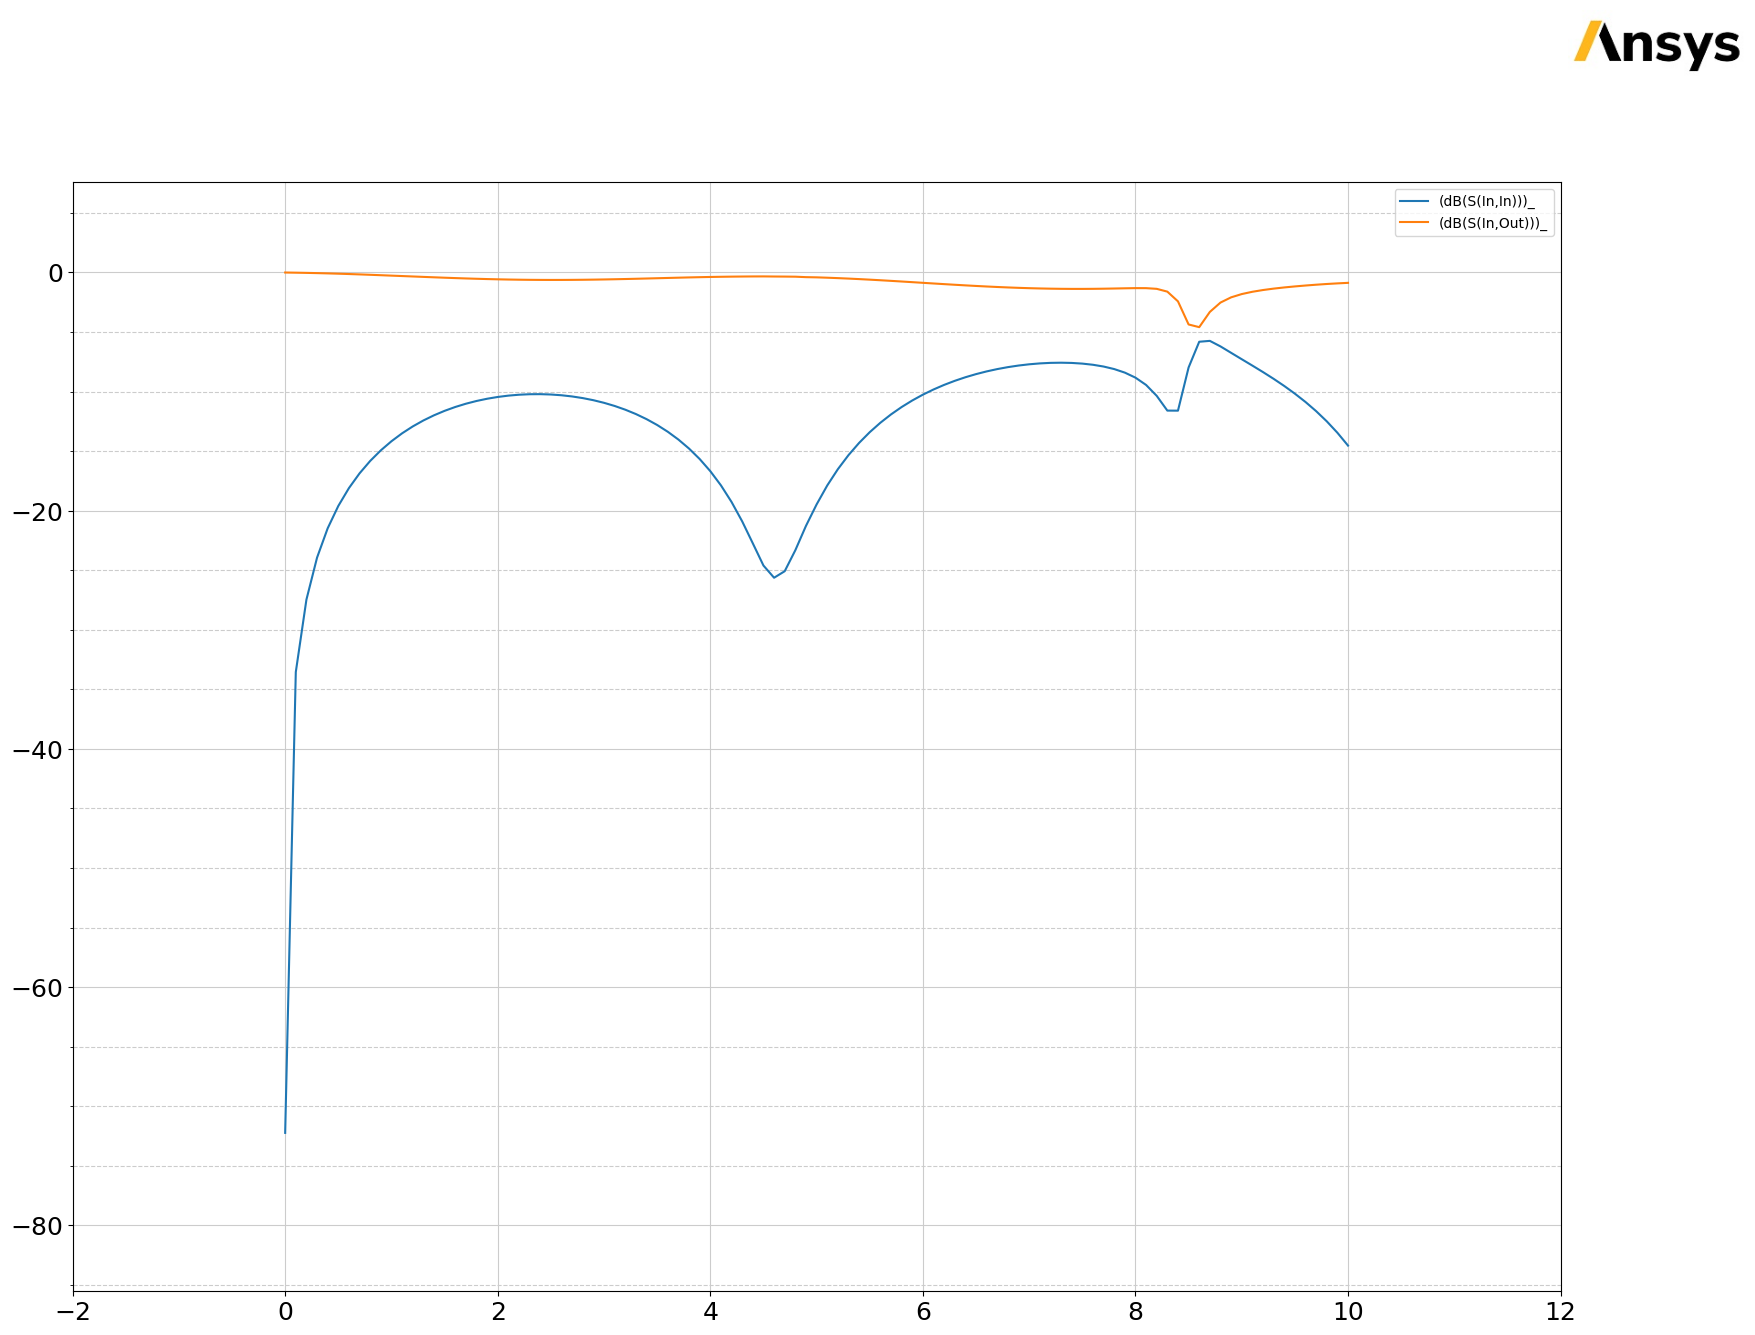

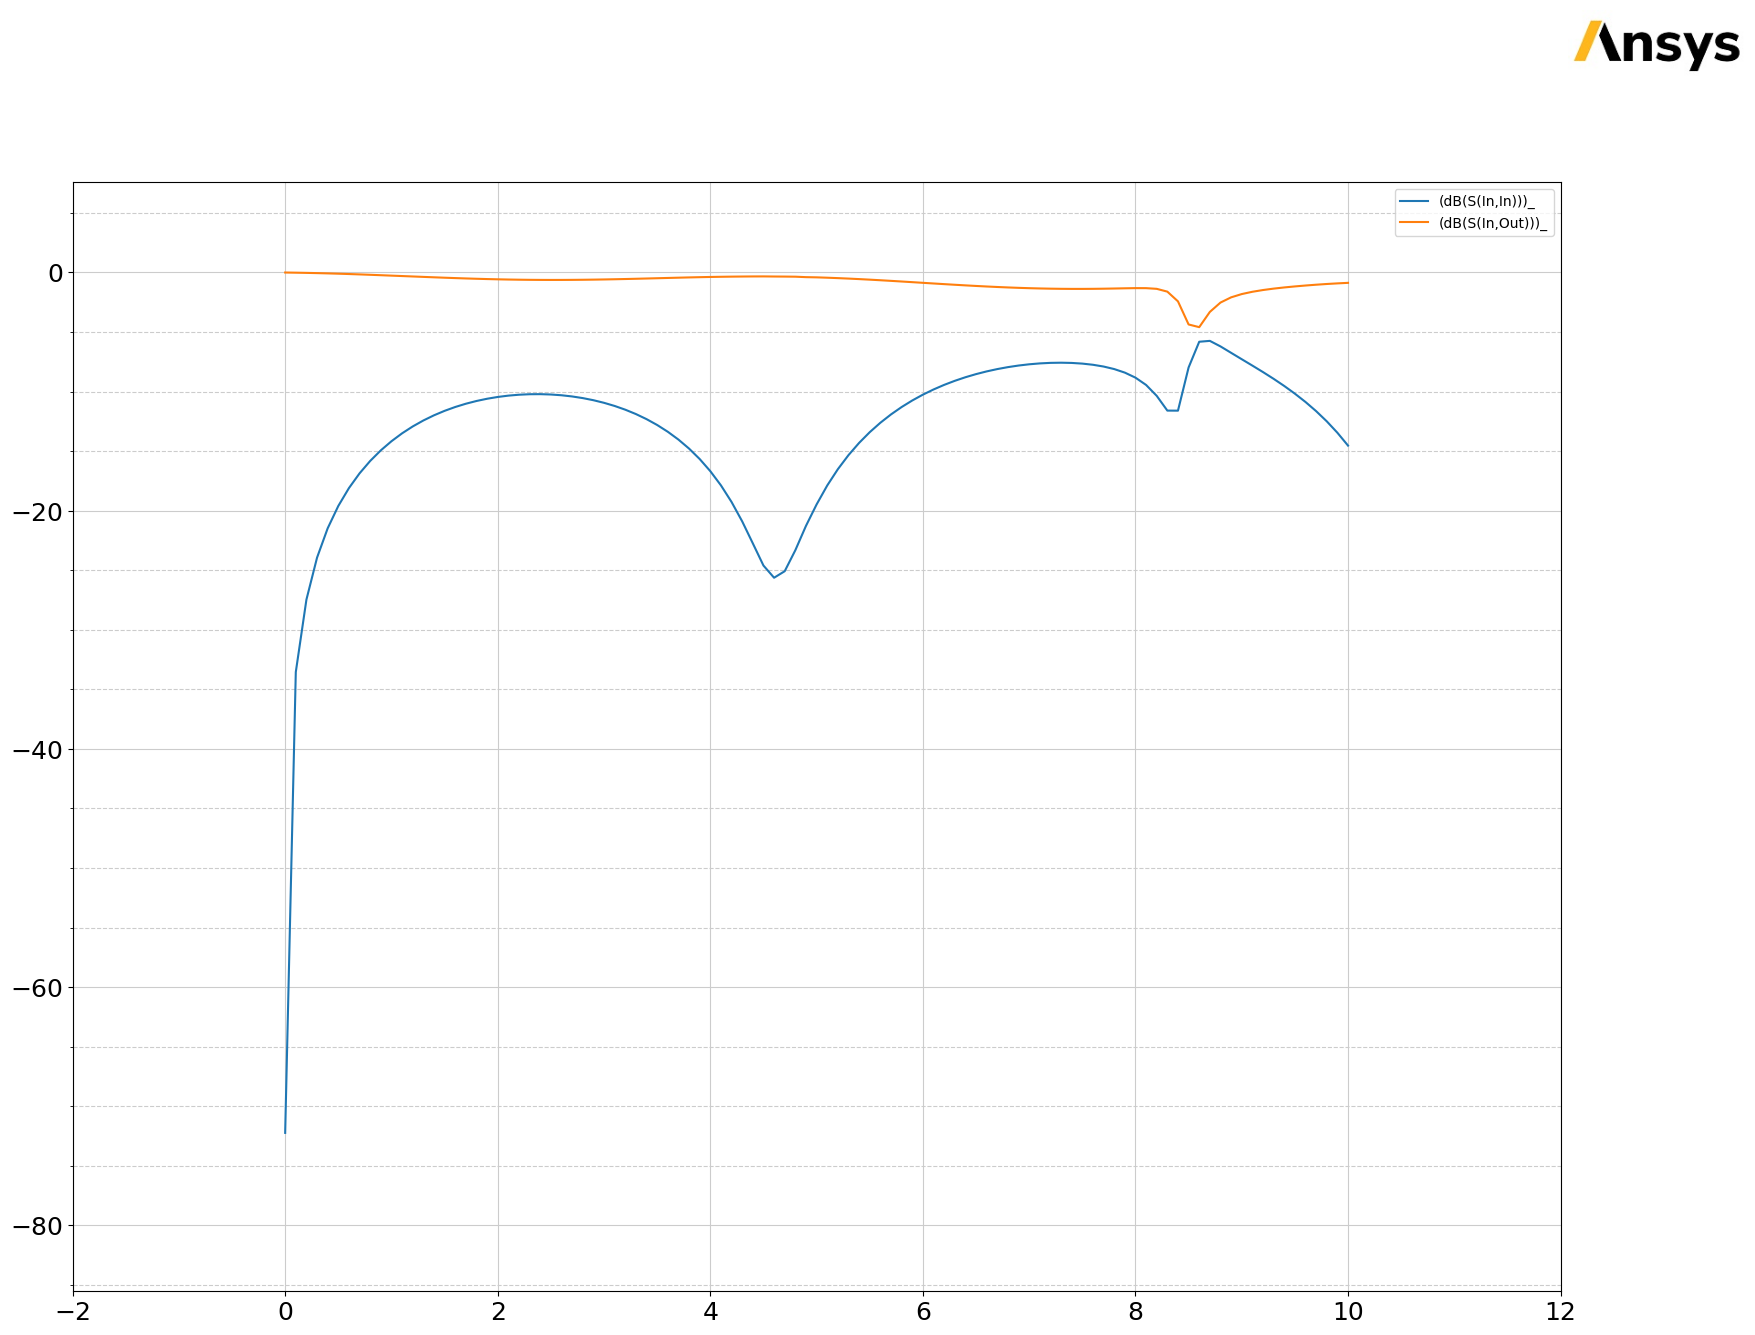

In [27]:
solutions = h3d.post.get_solution_data(expressions=["dB(S(In,In))", "dB(S(In,Out))"], context="Differential Pairs")
solutions.plot()

## Release AEDT

In [28]:
h3d.save_project()
h3d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project pcb Saved correctly


PyAEDT INFO: Desktop has been released and closed.


Note that the ground nets are only connected to each other due
to the wave ports. The problem with poor grounding can be seen in the
S-parameters. This example can be downloaded as a Jupyter Notebook, so
you can modify it. Try changing parameters or adding ground vias to improve performance.

The final cell cleans up the temporary directory, removing all files.

In [29]:
temp_folder.cleanup()